# Multiple Linear Regression: A Comprehensive Guide

Welcome! This notebook will guide you through multiple linear regression, including how to handle both numeric and categorical variables, interpret coefficients, avoid common pitfalls, and evaluate your model. We'll use the Auto MPG dataset for hands-on demonstrations and draw on best practices from the attached resources.

## Table of Contents
1. Introduction to Multiple Linear Regression
2. Exploring the Dataset
3. Numeric vs. Categorical Variables
4. One-Hot Encoding and the Dummy Variable Trap
5. Building and Interpreting a Multiple Regression Model
6. Handling Categorical Variables with Many Categories
7. Model Evaluation and Diagnostics
8. Best Practices and Common Pitfalls
9. Summary and Further Reading

## 1. Introduction to Multiple Linear Regression

Multiple linear regression is a statistical method for modeling the relationship between a target variable (dependent variable) and two or more predictor variables (independent variables). It allows us to estimate the effect of each predictor while controlling for the others. This is especially useful when real-world data is influenced by many factors at once.

**Key concepts:**
- Each coefficient represents the effect of that variable, holding others constant ("controlling for" other variables).
- Categorical variables must be converted to numeric form (dummy variables) before use.
- The choice of reference category for categorical variables affects interpretation.

In [1]:
## 2. Exploring the Dataset

import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("auto-mpg.csv")
data["make"] = data["car name"].str.split().apply(lambda x: x[0])
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,make
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,chevrolet
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,buick
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,plymouth
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,amc
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,ford


### Data Columns
- **mpg**: Miles per gallon (target)
- **cylinders, displacement, horsepower, weight, acceleration**: Numeric features
- **model year**: Year of the car
- **origin**: 1=USA, 2=Europe, 3=Asia (categorical, but encoded as numbers)
- **car name**: Name of the car (string)
- **make**: Engineered brand from car name (categorical)

## 3. Numeric vs. Categorical Variables

**Numeric variables** (e.g., weight, model year) can be used directly in regression. **Categorical variables** (e.g., origin, make) must be converted to numbers using one-hot encoding.

Let's visualize the relationship between numeric predictors and mpg.

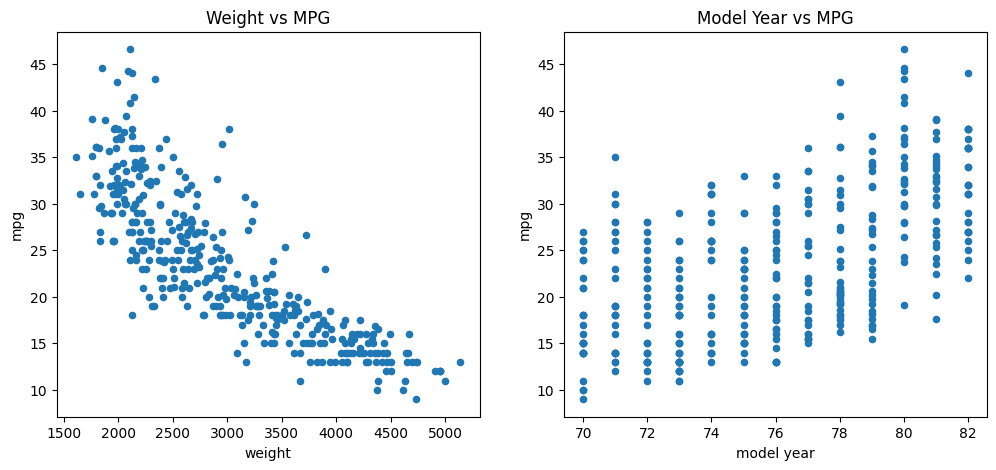

In [2]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
data.plot.scatter(x="weight", y="mpg", ax=ax1, title="Weight vs MPG")
data.plot.scatter(x="model year", y="mpg", ax=ax2, title="Model Year vs MPG")
plt.show()

### Categorical Variables: Why Not Use Numbers Directly?

Some categorical variables are encoded as numbers (e.g., origin). However, the numbers do not represent a true order or distance. For example, origin=2 (Europe) is not "twice" origin=1 (USA). We must use one-hot encoding to create separate columns for each category.

## 4. One-Hot Encoding and the Dummy Variable Trap

**One-hot encoding** creates a new column for each category. To avoid perfect multicollinearity (the "dummy variable trap"), we drop one column per categorical variable. The dropped column becomes the **reference category**.

Let's one-hot encode `origin` and demonstrate the dummy variable trap.

In [3]:
origin_dummies = pd.get_dummies(data["origin"], prefix="origin", dtype=int)
origin_dummies["sum"] = origin_dummies.sum(axis=1)
origin_dummies.head()

,origin_1,origin_2,origin_3,sum
0,1,0,0,1
1,1,0,0,1
2,1,0,0,1
3,1,0,0,1
4,1,0,0,1


Notice that for each row, only one dummy variable is 1 and the rest are 0. The sum is always 1, so any one column can be predicted from the others. This is perfect multicollinearity.

Let's drop the first column to avoid the trap:

When you create dummy variables for a categorical feature with three categories (like `origin` with values 1, 2, and 3), you get three new columns: `origin_1`, `origin_2`, and `origin_3`. For each row, exactly one of these columns is 1 and the others are 0. This means that if you know the values of two of the columns, you can always determine the value of the third (since the sum must be 1). This perfect predictability among the columns is called **perfect multicollinearity**.

In regression, perfect multicollinearity is a problem because the model cannot uniquely estimate the effect of each category—there are infinitely many solutions that fit the data equally well. This makes the regression coefficients unstable and unreliable.

**To solve this, we drop one of the dummy columns (usually the first).** The dropped category becomes the "reference" group, and the coefficients for the remaining dummies represent the difference relative to this reference. This ensures the predictors are independent and the regression can be estimated correctly.

In [4]:
data_encoded = pd.get_dummies(data, columns=["origin"], drop_first=True, dtype=int)
data_encoded.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,car name,make,origin_2,origin_3
0,18.0,8,307.0,130,3504,12.0,70,chevrolet chevelle malibu,chevrolet,0,0
1,15.0,8,350.0,165,3693,11.5,70,buick skylark 320,buick,0,0
2,18.0,8,318.0,150,3436,11.0,70,plymouth satellite,plymouth,0,0
3,16.0,8,304.0,150,3433,12.0,70,amc rebel sst,amc,0,0
4,17.0,8,302.0,140,3449,10.5,70,ford torino,ford,0,0


- `origin_2` = 1 if car is from Europe, 0 otherwise
- `origin_3` = 1 if car is from Asia, 0 otherwise
- If both are 0, the car is from the USA (reference category)

**Interpretation:** All coefficients for `origin_2` and `origin_3` are relative to the reference (USA).

## 5. Building and Interpreting a Multiple Regression Model

Let's predict `mpg` using `weight`, `model year`, and the one-hot encoded `origin` variables. We'll use the `statsmodels` library, which provides detailed output including p-values and R-squared.


In [5]:
import statsmodels.api as sm

X = data_encoded[["weight", "model year", "origin_2", "origin_3"]]
y = data_encoded["mpg"]
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     437.9
Date:                Sun, 29 Jun 2025   Prob (F-statistic):          3.53e-142
Time:                        21:39:08   Log-Likelihood:                -1026.1
No. Observations:                 392   AIC:                             2062.
Df Residuals:                     387   BIC:                             2082.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.3069      4.017     -4.557      0.0

### Interpreting the Results
- **const**: Predicted mpg for a car with all predictors at zero (not meaningful in practice)
- **weight**: Each additional pound reduces mpg (negative coefficient)
- **model year**: Newer cars tend to have higher mpg (positive coefficient)
- **origin_2**: European cars' mpg difference compared to US cars
- **origin_3**: Asian cars' mpg difference compared to US cars

**Adjusted R-squared** is a better metric than R-squared for multiple regression, as it penalizes adding unnecessary predictors.

## 6. Handling Categorical Variables with Many Categories

Let's use the `make` column as a predictor. First, we'll clean up typos and group rare makes as "other" (as in the attached resources).

In [6]:
# Clean up common typos
replacement_dict = {
    "chevroelt": "chevrolet",
    "mercedes": "mercedes-benz",
    "toyouta": "toyota",
    "vokswagen": "volkswagen",
    "maxda": "mazda",
    "chevy": "chevrolet",
    "vw": "volkswagen"
}
data["make"] = data["make"].replace(replacement_dict)
# Group rare makes as 'other'
make_counts = data["make"].value_counts()
rare_makes = make_counts[make_counts < 10].index
data["make"] = data["make"].replace(rare_makes, "other")

data["make"].value_counts()

make
other         61
ford          48
chevrolet     47
plymouth      31
dodge         28
amc           27
toyota        26
datsun        23
volkswagen    22
buick         17
pontiac       16
honda         13
mazda         12
mercury       11
oldsmobile    10
Name: count, dtype: int64

Now, let's one-hot encode `make` and build a new regression model. We'll drop the first make to set the reference category.

In [7]:
X = data[["weight", "model year", "make"]]
X = pd.get_dummies(X, columns=["make"], drop_first=True, dtype=int)
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     115.6
Date:                Sun, 29 Jun 2025   Prob (F-statistic):          5.53e-134
Time:                        21:39:08   Log-Likelihood:                -1012.2
No. Observations:                 392   AIC:                             2058.
Df Residuals:                     375   BIC:                             2126.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -17.5873      3.952     

#### How to Interpret the Regression Output

- **Intercept (const):** This is the predicted mpg for a car with all numeric predictors at zero and belonging to the reference make (the make that was dropped during one-hot encoding). While this value is not meaningful in practice, it serves as a baseline for interpreting other coefficients.

- **Numeric predictors (weight, model year):**
  - The coefficient for `weight` shows how much mpg decreases for each additional unit of weight, holding all other variables (including make) constant. A negative value means heavier cars get lower mpg.
  - The coefficient for `model year` shows how much mpg increases for each additional year, holding other variables constant. A positive value means newer cars tend to be more fuel efficient.

- **Make dummy variables:**
  - Each make's coefficient shows the difference in mpg between that make and the reference make, after accounting for weight and model year. For example, if `make_toyota` has a coefficient of 2.5, then (all else equal) Toyotas are predicted to get 2.5 mpg more than the reference make.
  - Only coefficients with low p-values (typically < 0.05) are considered statistically significant. If a make's coefficient is not significant, we cannot confidently say that make differs from the reference in terms of mpg.

- **Adjusted R-squared:** This tells you how well the model explains the variation in mpg, adjusting for the number of predictors. Higher values mean a better fit, but be cautious of overfitting if you include too many makes.

**In summary:**
- The regression results let you compare the fuel efficiency of different car makes, after controlling for weight and model year.
- Significant positive coefficients indicate makes that tend to have higher mpg than the reference, while significant negative coefficients indicate lower mpg.
- This approach helps isolate the effect of car make from other factors, giving a clearer picture of brand differences in fuel economy.

### Interpreting Categorical Coefficients
- Each make's coefficient shows the difference in mpg compared to the reference make (the one that was dropped).
- Only coefficients with low p-values (typically < 0.05) are statistically significant.
- If a categorical variable has many categories, most coefficients may not be significant. Consider grouping rare categories as "other".

## 7. Model Evaluation and Diagnostics

Let's use **Root Mean Squared Error (RMSE)** to measure prediction error, and visualize the effect of car make on mpg.

### What is Happening in Model Evaluation (Part 7)?

In this section, we are assessing how well our multiple regression model predicts the target variable (`mpg`). Here’s what each step is doing, with reference to the evaluation notebook:

- **Root Mean Squared Error (RMSE):**
  - RMSE is a common error-based metric that tells us, on average, how far off our model’s predictions are from the actual values, measured in the same units as the target (here, miles per gallon).
  - A lower RMSE means better predictive accuracy. For example, an RMSE of 3 means that, on average, our model’s predictions are off by about 3 mpg.
  - RMSE penalizes larger errors more than smaller ones (because errors are squared before averaging), making it sensitive to outliers.
  - This is similar to the calculation and interpretation shown in the evaluation notebook, where both MAE (mean absolute error) and RMSE are discussed as ways to summarize model error.

- **Visualizing Make Coefficients:**
  - The bar plot shows the estimated effect of each car make on mpg, after controlling for weight and model year. Each bar represents how much higher or lower the predicted mpg is for that make compared to the reference make.
  - This helps you quickly see which brands tend to have better or worse fuel efficiency, all else being equal.

- **Why Use These Metrics?**
  - R-squared and adjusted R-squared (discussed earlier) tell you how much of the variance in mpg is explained by the model, but they don’t tell you about the size of the errors.
  - Error-based metrics like RMSE (and MAE, as shown in the evaluation notebook) give you a more direct sense of how accurate your predictions are in real-world terms.

- **Model Diagnostics:**
  - The checklist reminds you to look for multicollinearity (predictors that are too similar), focus on significant coefficients, and remember that all categorical effects are relative to the reference group.


#### Additional Model Evaluation Metrics

Beyond RMSE, there are several other important metrics for evaluating multiple regression models, as discussed in the evaluation notebook:

- **Mean Absolute Error (MAE):**
  - MAE is the average of the absolute differences between the predicted and actual values. Like RMSE, it is measured in the same units as the target variable (mpg).
  - MAE is less sensitive to outliers than RMSE because it does not square the errors. It gives a straightforward interpretation: "On average, our predictions are off by this many mpg."
  - Lower MAE values indicate better model performance.

- **Adjusted R-Squared:**
  - Adjusted R-squared improves on regular R-squared by penalizing the addition of unnecessary predictors. It only increases if a new predictor improves the model more than would be expected by chance.
  - This makes it a better metric for comparing models with different numbers of predictors.
  - You can find adjusted R-squared in the regression summary output, or calculate it manually as shown in the evaluation notebook.

- **F-Statistic and F-Statistic p-value:**
  - The F-statistic tests whether your model explains a significant amount of variance in the target variable compared to a model with no predictors.
  - A very small p-value (typically < 0.05) means your model is statistically significant overall.

- **R-Squared:**
  - R-squared measures the proportion of variance in the target variable explained by the model. However, it always increases as you add more predictors, even if they are not useful.
  - This is why adjusted R-squared is preferred for multiple regression.

**Summary:**
- Use a combination of metrics to evaluate your model: RMSE and MAE for average prediction error, adjusted R-squared for overall fit, and the F-statistic for statistical significance.
- These metrics together give you a more complete picture of how well your regression model is performing and whether it is likely to generalize to new data.

C:\Users\Anarchy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Root Mean Squared Error (RMSE): 3.20


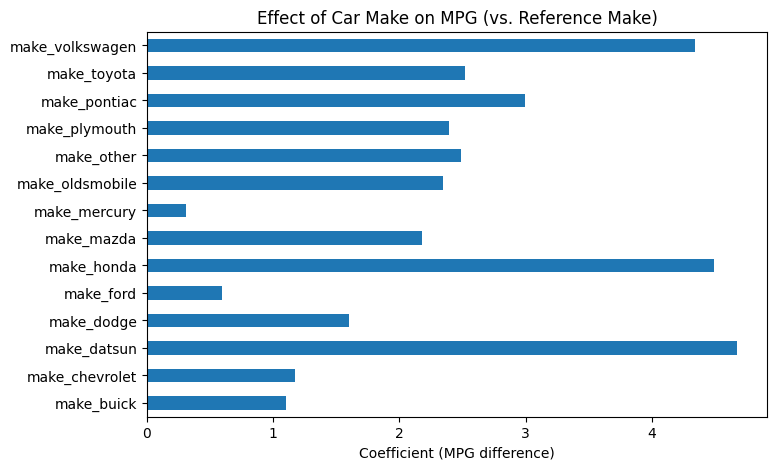

In [8]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y, results.predict(X), squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Visualize make coefficients
coefs = results.params.filter(like="make_")
coefs.plot.barh(figsize=(8,5))
plt.title("Effect of Car Make on MPG (vs. Reference Make)")
plt.xlabel("Coefficient (MPG difference)")
plt.show()

#### Explanation of the Code and Output Graph

- **Root Mean Squared Error (RMSE):**
  - The code calculates RMSE, which measures the average prediction error of the model in the same units as the target variable (mpg).
  - For example, if RMSE is 3.2, it means that, on average, the model's predictions are off by about 3.2 miles per gallon.
  - RMSE is useful for understanding how well the model is likely to perform on new, unseen data. Lower values indicate better predictive accuracy.

- **Bar Graph of Make Coefficients:**
  - The graph shows the estimated effect of each car make on mpg, after controlling for weight and model year.
  - Each bar represents the coefficient for a specific make, which tells you how much higher or lower the predicted mpg is for that make compared to the reference make (the one that was dropped during one-hot encoding).
  - Positive bars indicate makes that tend to have higher mpg than the reference, while negative bars indicate makes with lower mpg.
  - The length of each bar shows the size of the effect, and the direction (left or right) shows whether the effect is positive or negative.
  - This visualization helps you quickly identify which car brands are associated with better or worse fuel efficiency, all else being equal.

**In summary:**
- The RMSE gives you a sense of the model's overall prediction error.
- The bar graph provides an intuitive way to compare the relative fuel efficiency of different car makes, after accounting for other factors in the model.

### Model Diagnostics

- **Check for multicollinearity**: Avoid including highly correlated predictors (e.g., both origin and make, if make implies origin).
- **Interpret only significant coefficients**: Focus on predictors with p-values < 0.05.
- **Reference category matters**: All categorical coefficients are relative to the dropped category.

## 8. Best Practices and Common Pitfalls

- **Always preprocess categorical variables** (one-hot encoding, grouping rare categories)
- **Drop one dummy variable per category** to avoid the dummy variable trap
- **Don't drop predictors just because they're not significant**—use data understanding
- **Adjusted R-squared** is better than R-squared for comparing models with different numbers of predictors
- **Interpret coefficients in context**: For categorical variables, coefficients are always relative to the reference category

## 9. Summary and Further Reading

- Multiple linear regression lets us model the effect of several variables at once
- Categorical variables must be converted to numbers (one-hot encoding)
- Always drop one dummy variable per category to avoid the dummy variable trap
- Model evaluation metrics like RMSE and adjusted R-squared help us understand prediction accuracy
- Data cleaning and thoughtful feature selection are crucial for meaningful results

**Further Reading:**
- [StatQuest: Multiple Regression](https://www.youtube.com/watch?v=JvS2triCgOY)
- [pandas.get_dummies documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)
- [Statsmodels OLS Regression](https://www.statsmodels.org/stable/regression.html)

Congratulations! You now have a solid foundation in multiple linear regression, including how to handle categorical variables, interpret coefficients, and avoid common pitfalls. Try experimenting with other features or datasets to deepen your understanding.